In [5]:
!pip install haystack-ai chroma-haystack

# RAG pipeline with Evaluation.
when evaluating RAG pipeline there are three main types of evaluation:
1. evaluating the retriever
2. evaluating the generator
3. evaluating the system as a whole

## To evaluate the retriever we have different methods given by Haystack:

1. ***ContextRelevanceEvaluator***: uses an LLM to evaluate whether contexts are relevant to a question. It does not require ground truth labels.
4. ***DocumentRecallEvaluator***: evaluates documents retrieved by Haystack pipelines using ground truth labels. It checks how many of the ground truth documents were retrieved. This metric is called recall.
3. ***DocumentMRREvaluator***:
2. ***DocumentMAPEvaluator***:
5. ***DocumentNDCGEvaluator***:

## To evaluate the generator we have different methods given by Haystack:
1. ***FaithfulnessEvaluator***: Uses an LLM to evaluate whether a generated answer can be inferred from the provided contexts. Does not require ground truth labels.
2. ***SASEvaluator***:

RagasEvaluator
DeepEvalEvaluator



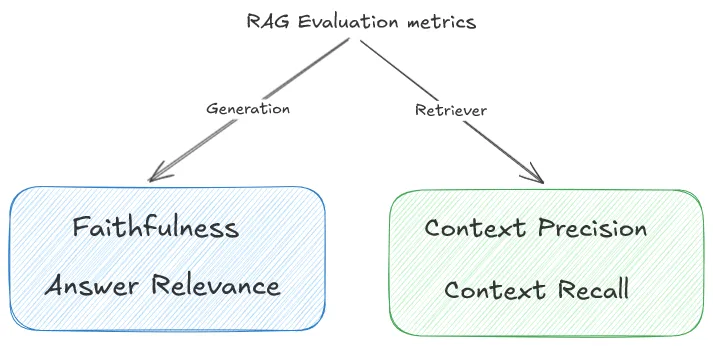

## Evaluation


### installing dataset for evaluation

going to use Arabic Reading Comprehension Dataset (ARCD):


In [6]:
import json

try:
    with open("/content/arcd.json", "r", encoding="utf-8") as f:
        data = json.load(f)
except json.JSONDecodeError as e:
    print(f"JSON Decode Error: {e}")

In [7]:
len(data["data"])

155

#### the structure if the ARCD dataset
<
file.json<br>
├── "data"<br>
│   └── [i]<br>
│       ├── "paragraphs"<br>
│       │   └── [j]<br>
│       │       ├── "context": "paragraph text"<br>
│       │       └── "qas"<br>
│       │           └── [k]<br>
│       │               ├── "answers"<br>
│       │               │   └── [l]<br>
│       │               │       ├── "answer_start": N<br>
│       │               │       └── "text": "answer"<br>
│       │               ├── "id": "<uuid>"<br>
│       │               └── "question": "paragraph question?"<br>
│       └── "title": "document id"<br>
└── "version": 1.1<br>

let's extract the contexts to files

In [8]:
import json
import os
import re

# Function to sanitize filenames (remove invalid characters)
def sanitize_filename(title):
    # Replace invalid characters with underscores
    return re.sub(r'[<>:"/\\|?*\x00-\x1F]', '_', title)

# Load the JSON file
input_file = "/content/arcd.json"  # Adjust path if needed
output_dir = "/content/extracted_texts"  # Output directory for text files

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Read the input JSON file
with open(input_file, "r", encoding="utf-8") as f:
    data = json.load(f)

# Process each document
for doc in data["data"]:
    title = doc.get("title", "untitled")  # Default to "untitled" if no title
    sanitized_title = sanitize_filename(title)
    output_file = os.path.join(output_dir, f"{sanitized_title}.txt")

    with open(output_file, "w", encoding="utf-8") as f:
        for para in doc.get("paragraphs", []):
            context = para.get("context", "")
            f.write(context + "\n\n")  # Add double newline between paragraphs

    print(f"Saved {output_file}")

Saved /content/extracted_texts/جمال خاشقجي.txt
Saved /content/extracted_texts/السعودية.txt
Saved /content/extracted_texts/مصر.txt
Saved /content/extracted_texts/محمد.txt
Saved /content/extracted_texts/المغرب.txt
Saved /content/extracted_texts/الدولة العثمانية.txt
Saved /content/extracted_texts/الولايات المتحدة.txt
Saved /content/extracted_texts/الحرب العالمية الأولى.txt
Saved /content/extracted_texts/الحرب العالمية الثانية.txt
Saved /content/extracted_texts/كأس العالم 2018.txt
Saved /content/extracted_texts/صلاح الدين الأيوبي.txt
Saved /content/extracted_texts/العراق.txt
Saved /content/extracted_texts/ألبرت أينشتاين.txt
Saved /content/extracted_texts/سلطنة عمان.txt
Saved /content/extracted_texts/سوريا.txt
Saved /content/extracted_texts/الهند.txt
Saved /content/extracted_texts/فلسطين.txt
Saved /content/extracted_texts/سرطان.txt
Saved /content/extracted_texts/شيرين عبد الوهاب.txt
Saved /content/extracted_texts/الصين.txt
Saved /content/extracted_texts/كرة القدم.txt
Saved /content/extracte

let's extract the questions into a file for testing.

In [9]:
import json
import os

# Define input and output file paths
input_file = "/content/arcd.json"  # Path to your original JSON file
output_file = "/content/questions_only.json"  # Output file for extracted questions

# Load the JSON data
with open(input_file, "r", encoding="utf-8") as f:
    data = json.load(f)

# Collect all questions
questions = []
for doc in data["data"]:
    for para in doc["paragraphs"]:
        for qa in para["qas"]:
            questions.append(qa["question"])

# Save to a new JSON file
output_data = {"questions": questions}
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(output_data, f, ensure_ascii=False, indent=2)

print(f"Saved {len(questions)} questions to {output_file}")

Saved 1395 questions to /content/questions_only.json


### building the Pipeline

In [10]:
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 30.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.31.4
    Uninstalling huggingface-hub-0.31.4:
      Successfully uninstalled huggingface-hub-0.31.4


In [11]:
from haystack import component
from haystack import Pipeline, Document
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy
from haystack_integrations.document_stores.chroma import ChromaDocumentStore

In [12]:
document_store = ChromaDocumentStore(collection_name='arcd_evaluation', embedding_function='default', persist_path='/content/vectordb')


indexing pipeline

In [13]:
import os
import re

@component
class ArcdFilesInjestor:

    @classmethod
    def validate(cls, input_dir: str):
        if not os.path.exists(input_dir):
            raise ValueError(f"Directory '{input_dir}' does not exist.")

    @component.output_types(documents=list[Document])
    def run(self, directory: str):
        documents = []
        for filename in os.listdir(directory):
            if filename.endswith(".txt"):
                file_path = os.path.join(directory, filename)
                with open(file_path, "r", encoding="utf-8") as f:
                    raw_text = f.read()

                # Step 1: Split by double newlines into paragraphs
                paragraphs = re.split(r'\n\s*\n', raw_text.strip())

                # Step 2: Replace newlines within paragraphs with spaces
                processed_paragraphs = [re.sub(r'\n', ' ', para) for para in paragraphs]

                # Step 3: Recombine paragraphs with single newlines
                processed_text = "\n".join(processed_paragraphs)

                # Step 4: Create a Document for the file
                doc = Document(
                    content=processed_text,
                    meta={"file_name": filename}
                )
                documents.append(doc)

        return {"documents": documents}

In [14]:
pipeline = Pipeline()
pipeline.add_component('injestor', ArcdFilesInjestor())
pipeline.add_component('cleaner', DocumentCleaner(remove_empty_lines=True, remove_extra_whitespaces=True, remove_repeated_substrings=False))
pipeline.add_component('splitter', DocumentSplitter(split_by='sentence', split_length=3, split_overlap=1))
pipeline.add_component('writer', DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP))

pipeline.connect('injestor.documents', 'cleaner.documents')
pipeline.connect('cleaner.documents', 'splitter.documents')
pipeline.connect('splitter.documents', 'writer.documents')



🚅 Components
  - injestor: ArcdFilesInjestor
  - cleaner: DocumentCleaner
  - splitter: DocumentSplitter
  - writer: DocumentWriter
🛤️ Connections
  - injestor.documents -> cleaner.documents (list[Document])
  - cleaner.documents -> splitter.documents (List[Document])
  - splitter.documents -> writer.documents (List[Document])

In [15]:
# Run pipeline
pipeline.run({
    'injestor': {'directory': '/content/extracted_texts'},
})

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:02<00:00, 41.0MiB/s]


{'writer': {'documents_written': 648}}

In [16]:
from haystack.components.builders import ChatPromptBuilder, PromptBuilder
from haystack.dataclasses import ChatMessage
from haystack.utils import Secret
from haystack.components.generators.chat import HuggingFaceAPIChatGenerator, HuggingFaceLocalChatGenerator
from haystack.components.generators import HuggingFaceLocalGenerator
from haystack.components.routers import ConditionalRouter
from haystack_integrations.components.retrievers.chroma import ChromaQueryTextRetriever
from haystack import component

In [17]:
system_prompt = """you are arabic virtual assistant, you answer user queries in arabic."""

main_prompt_template =system_prompt +  """
ROLE AND CONTEXT:
You are a knowledgeable assistant. Your task is to provide accurate and detailed answers to queries. Use the provided excerpts and references from useful resources to support your answers.

INSTRUCTIONS:
1. Identify the relevant sections of the excerpts provided.
2. Provide a concise and informative response.
3. Ensure your responses are clear and easy to understand.

EXCERPTS:
{% for doc in documents %}
    excerpt: {{ doc.content }}
{% endfor %}

CONSIDERATIONS:
- If the query cannot be answered given the provided documents, return 'no_answer'

Query: {{query}}
Answer:
"""

fallback_prompt_template = system_prompt + """
User entered a query that cannot be answered with the excerpts provided.
The query was: {{query}}.
Let the user know why the question cannot be answered. Be brief.
"""

In [18]:
model_name='CohereLabs/c4ai-command-r7b-arabic-02-2025'
HF_API_TOKEN = os.environ.get('HF_API_TOKEN')

In [19]:
retriever = ChromaQueryTextRetriever(document_store=document_store, top_k=5)
template1 = [ChatMessage.from_user(main_prompt_template)]
main_promptbuilder = ChatPromptBuilder(template=template1)
template2 = [ChatMessage.from_user(fallback_prompt_template)]
fallback_promptbuilder = ChatPromptBuilder(template=template2)
# main_llm = HuggingFaceLocalChatGenerator(model="silma-ai/SILMA-Kashif-2B-Instruct-v1.0")
main_llm = HuggingFaceLocalChatGenerator(model="Qwen/Qwen2.5-1.5B-Instruct")
# main_llm = HuggingFaceLocalChatGenerator(model="Qwen/Qwen2-1.5B-Instruct")
# main_llm = HuggingFaceLocalChatGenerator(model="google/gemma-2-2b-it")

fallback_llm = HuggingFaceAPIChatGenerator(
    api_type="serverless_inference_api",
    api_params={"model": model_name},
    token=Secret.from_token(HF_API_TOKEN))

@component
class ChatMessageToTextConverter:
    @component.output_types(replies_text=list[str])
    def run(self, replies: list[ChatMessage], **kwargs):
        # replies: list of ChatMessage objects
        texts = [msg.text for msg in replies]
        return {"replies_text": texts}

conditional_router = ConditionalRouter([
    {
        "condition": "{{'no_answer' not in replies[0].text }}",
        "output": "{{replies}}",
        "output_name": "replies",
        "output_type": list[str],
    },
    {
        "condition": "{{'no_answer' in replies[0].text }}",
        "output": "{{query}}",
        "output_name": "go_to_fallback",
        "output_type": str,
    },
])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [20]:
# Setup pipeline
pipeline = Pipeline()
pipeline.add_component('retriever', retriever)
pipeline.add_component('main_promptbuilder', main_promptbuilder)
pipeline.add_component('fallback_promptbuilder', fallback_promptbuilder)
pipeline.add_component('main_llm', main_llm)
pipeline.add_component('fallback_llm', fallback_llm)
pipeline.add_component('conditional_router', conditional_router)
pipeline.add_component('converter',ChatMessageToTextConverter())

pipeline.connect('retriever.documents', 'main_promptbuilder.documents')
pipeline.connect('main_promptbuilder.prompt', 'main_llm.messages')

pipeline.connect('main_llm.replies', 'converter.replies')
pipeline.connect('converter.replies_text', 'conditional_router.replies')

pipeline.connect('conditional_router.go_to_fallback', 'fallback_promptbuilder.query')
pipeline.connect('fallback_promptbuilder.prompt', 'fallback_llm.messages')

🚅 Components
  - retriever: ChromaQueryTextRetriever
  - main_promptbuilder: ChatPromptBuilder
  - fallback_promptbuilder: ChatPromptBuilder
  - main_llm: HuggingFaceLocalChatGenerator
  - fallback_llm: HuggingFaceAPIChatGenerator
  - conditional_router: ConditionalRouter
  - converter: ChatMessageToTextConverter
🛤️ Connections
  - retriever.documents -> main_promptbuilder.documents (List[Document])
  - main_promptbuilder.prompt -> main_llm.messages (List[ChatMessage])
  - fallback_promptbuilder.prompt -> fallback_llm.messages (List[ChatMessage])
  - main_llm.replies -> converter.replies (List[ChatMessage])
  - conditional_router.go_to_fallback -> fallback_promptbuilder.query (str)
  - converter.replies_text -> conditional_router.replies (list[str])

In [35]:
import random  # Added for shuffling

def run(question: str):
  results = pipeline.run({
      'retriever': {'query': q},
      'main_promptbuilder': {'query': q},
      'conditional_router': {'query': q},
  }, include_outputs_from={'retriever'})
  return results

def get_context(results):
  retriever_output = results["retriever"]
  context = []
  for d in retriever_output["documents"]:
    context.append(d.content)
  return context


def get_reply(results):
  response = results.get('conditional_router') or results.get('fallback_llm')
  reply = response['replies'][0].replace('\n', '')
  return reply

def get_questions(file_path: str = "arcd.json") -> dict:
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    qac = []

    for doc in data.get("data", []):
        for para in doc.get("paragraphs", []):
            context = para.get("context", "")
            for qa in para.get("qas", []):
                question = qa.get("question", "").strip()
                answers = qa.get("answers", [])
                if answers:
                    given_answer = answers[0].get("text", "").strip()
                else:
                    given_answer = ""

                qac.append({
                    "question": question,
                    "context": context,
                    "given_answer": given_answer
                })
    random.shuffle(qac)

    return {"qac": qac}

`Next step build evaluation pipeline`

In [37]:
qac = get_questions()['qac']
qac = qac[:100]
print(len(qac))


100


In [38]:
predicted_data = []
for item  in qac:
  q = item['question']
  results = run(q)
  predicted_context = get_context(results)
  predicted_answer = get_reply(results)
  predicted_data.append({ **item , "predicted_answer":predicted_answer, "predicted_context":predicted_context})

  # print(f'Question: {q}')
  # print(f'Response: {reply}')
  # print('-------------------------------------------------\n')

predicted_data[0]

{'question': 'ماهي حدود دولة السلاطين العثمانية من جهة الشمال ؟',
 'context': 'سلاطين الدولة العُثمانيَّة هُم مجموعةُ من السلاطين التُرك المُسلمين السُنَّة من آل عُثمان حكموا إمبراطوريَّة مُترامية الأطراف امتدَّت أراضيها على ثلاث قارَّات، وقد جمعوا بين الخِلافة الإسلاميَّة والسلطنة بدايةً من عام 1517م، ودام مُلكُهم من عام 1299م إلى عام 1922م. امتدَّت دولتهم عندما بلغت أوج عظمتها وقوَّتها من المجر شمالًا إلى الحبشة جنوبًا (ما يُعرف بالصومال حاليًّا)، ومن المغرب الأوسط (الجزائر حاليًّا) غربًا إلى أذربيجان شرقًا (بعض أنحاء مُحافظة أذربيجان الشرقيَّة في إيران حاليًّا).',
 'given_answer': 'من المجر شمالًا',
 'predicted_answer': 'حدود الدولة العثمانية من الشمال كانت تقاس مع دول البلقان مثل جمهورية التشيكوسlodوفاكيا والدنمارك والسويد والنرويج.',
 'predicted_context': ['انتقد خاشقجي بصورة كبيرة ولي العهد السعودي محمد بن سلمان، والملك سلمان بن عبد العزيز. وكذلك عارض التدخل العسكري في اليمن.',
  'إيران موطن لواحدة من أقدم الحضارات في العالم. أول سلالة حاكمة شكلت في إيران خلال المملكة العيلامية ف

In [39]:
import json

# Define the output file path
model_used = '--qwen2_5-1_5B'
output_file = "predicted_data" + model_used + ".json"

# Save to JSON file
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(predicted_data, f, ensure_ascii=False, indent=2)

In [41]:
predicted_data[0]

{'question': 'ماهي حدود دولة السلاطين العثمانية من جهة الشمال ؟',
 'context': 'سلاطين الدولة العُثمانيَّة هُم مجموعةُ من السلاطين التُرك المُسلمين السُنَّة من آل عُثمان حكموا إمبراطوريَّة مُترامية الأطراف امتدَّت أراضيها على ثلاث قارَّات، وقد جمعوا بين الخِلافة الإسلاميَّة والسلطنة بدايةً من عام 1517م، ودام مُلكُهم من عام 1299م إلى عام 1922م. امتدَّت دولتهم عندما بلغت أوج عظمتها وقوَّتها من المجر شمالًا إلى الحبشة جنوبًا (ما يُعرف بالصومال حاليًّا)، ومن المغرب الأوسط (الجزائر حاليًّا) غربًا إلى أذربيجان شرقًا (بعض أنحاء مُحافظة أذربيجان الشرقيَّة في إيران حاليًّا).',
 'given_answer': 'من المجر شمالًا',
 'predicted_answer': 'حدود الدولة العثمانية من الشمال كانت تقاس مع دول البلقان مثل جمهورية التشيكوسlodوفاكيا والدنمارك والسويد والنرويج.',
 'predicted_context': ['انتقد خاشقجي بصورة كبيرة ولي العهد السعودي محمد بن سلمان، والملك سلمان بن عبد العزيز. وكذلك عارض التدخل العسكري في اليمن.',
  'إيران موطن لواحدة من أقدم الحضارات في العالم. أول سلالة حاكمة شكلت في إيران خلال المملكة العيلامية ف

### Evaluation Pipeline

In [52]:
from haystack.components.evaluators.document_mrr import DocumentMRREvaluator
from haystack.components.evaluators.faithfulness import FaithfulnessEvaluator
from haystack.components.evaluators.sas_evaluator import SASEvaluator

eval_pipeline = Pipeline()
# eval_pipeline.add_component("doc_mrr_evaluator", DocumentMRREvaluator())
# eval_pipeline.add_component("faithfulness", FaithfulnessEvaluator())
eval_pipeline.add_component("sas_evaluator", SASEvaluator(model="sentence-transformers/all-MiniLM-L6-v2"))


In [53]:
ground_truth_docs = [Document(content = item['context']) for item in predicted_data]
retrieved_docs = [[Document(content = p_context_text) for p_context_text in item['predicted_context']] for item in predicted_data]
ground_truth_answers = [item['given_answer'] for item in predicted_data]
rag_answers = [item['predicted_answer'] for item in predicted_data]
questions = [item['question'] for item in predicted_data]

In [54]:
eval_results = eval_pipeline.run(
    {
        "sas_evaluator": {"predicted_answers": rag_answers, "ground_truth_answers": list(ground_truth_answers)},
    }
)

In [55]:
from haystack.evaluation.eval_run_result import EvaluationRunResult

inputs = {
    "question": list(questions),
    "contexts": list([d.content] for d in ground_truth_docs),
    "answer": list(ground_truth_answers),
    "predicted_answer": rag_answers,
}

evaluation_result = EvaluationRunResult(run_name="pubmed_rag_pipeline", inputs=inputs, results=eval_results)
evaluation_result.aggregated_report()

{'metrics': ['sas_evaluator'], 'score': [np.float64(0.41954220648854973)]}